# Pretraining GPT Model on Large Dataset & Finetuning on Shakespeare Dataset
----

1. Find a dataset that is very large, so large that you can't see a gap between train and val loss. Pretrain the transformer on this data, then initialize with that model and finetune it on tiny shakespeare with a smaller number of steps and lower learning rate. Can you obtain a lower validation loss by the use of pretraining?
<br><br>
**<u>Comment:</u> The validation loss on the shakespeare dataset without pretraining is $\textbf{1.5597}$.**
>- Number of steps: $5000$
>- Learning rate: $6e^{-4}$

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Let's use the huggingface datasets library to gain access to a large collection of nlp datasets. For this exercise, I've chosen to use the **cnn_dailymail** dataset, which is contains over $\textbf{300,000}$ <u>online news articles. </u>

This dataset is also already split into a training and validation set, which is nice.

In [30]:
from datasets import load_dataset
from copy import deepcopy
import string
import time, timeit
import math, re
import random
from tqdm import tqdm
import csv, os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [3]:
data = load_dataset("ccdv/cnn_dailymail", "1.0.0", trust_remote_code=True)
train_data = data['train']
val_data = data['validation']

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
len(train_data), len(val_data)

(287113, 13368)

In [5]:
train_data[1]

{'article': '(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory 

In [6]:
# torch.randint??

In [7]:
indices = torch.randint(len(train_data), (4,))
indices
for i in indices:
    print(i)
#     train_data[i.item()])

tensor(256824)
tensor(4194)
tensor(191757)
tensor(221651)


In [8]:
len(set(train_data[1]['article']))

66

In [9]:
unique_characters = set()
for i in range(200):
#     print(set(train_data[i]['article']), len(set(train_data[i]['article'])))
    unique_characters.update(set(train_data[i]['article']))
print(unique_characters, len(unique_characters))

{'+', 'c', '|', 'L', 'R', 'w', 'U', '"', 'd', '§', "'", 'T', '8', '½', '_', 'á', '9', 'ñ', 'ø', '»', '1', '«', 'Â', 'z', 'H', '₩', '6', 'G', 'Q', 's', 'N', '7', 'ê', '&', 'Z', '%', 'B', ';', '\u200b', '-', ']', 'M', '!', 'Y', 'X', '2', 'F', '.', 'E', 'p', '/', 'v', 'K', '€', '@', 'g', '4', 'x', 'l', '(', '?', 'k', 'e', 'Ã', '\xa0', '3', 'é', 'i', 'b', 'h', '#', 'o', '[', 'ë', 'ć', 'C', '©', 'S', 'D', 'j', 'n', '$', 'f', 'm', 'r', 'P', ')', 'I', '—', 'V', ':', 'W', 'ž', 'J', 'y', 'ö', 'q', '0', '*', 'u', '¢', 't', '°', 'A', 'a', '5', 'O', 'ç', ',', ' ', 'â'} 111


In [10]:
def count_key_occurrences(data, key):
    count = sum(key in entry for entry in data if isinstance(entry, dict))
    return count

# Example usage
key_count = count_key_occurrences(train_data, 'article')
print(f"Number of dictionaries with 'article' key: {key_count}")

Number of dictionaries with 'article' key: 287113


In [11]:
type(train_data)

datasets.arrow_dataset.Dataset

In [12]:
num_articles = len(train_data['article'])
num_highlights = len(train_data['highlights'])
num_ids = len(train_data['id'])
print(f"Number of articles: {num_articles}")
print(f"Number of highlights: {num_highlights}")
print(f"Number of ids: {num_ids}")

Number of articles: 287113
Number of highlights: 287113
Number of ids: 287113


In [13]:
# Check type and contents
print(f"Type for 'article': {type(train_data['article'])}")
print(f"Type for 'highlight': {type(train_data['highlights'])}")
print(f"Type for 'id': {type(train_data['id'])}")


Type for 'article': <class 'list'>
Type for 'highlight': <class 'list'>
Type for 'id': <class 'list'>


In [14]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)
    
    
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head                                                     # nh        
        self.n_embd = n_embd
        self.head_size = n_embd // n_head                                        # hs
        self.scale = self.head_size ** -0.5

        # key, query, value projections for all heads, but in a batch & output projection
        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd, bias=bias)
        self.out_proj = nn.Linear(n_embd, n_embd, bias=bias)
        
        # regularization: dropout
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
#         self.dropout = nn.Dropout(dropout)

        # mask for self-attention
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size))
        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        qkv = self.qkv_proj(x)
        qkv = qkv.view(B, T, self.n_head, 3 * self.head_size)
        
        # splits the qkv tensor into three tensors along the last dimension to get Q, K, V tensors
        q, k, v = qkv.chunk(3, dim=-1)                                           # (B, T, nh, hs)
        q = q.transpose(1, 2)                                                    # (B, nh, T, hs)
        k = k.transpose(1, 2)                                                    # (B, nh, T, hs)
        v = v.transpose(1, 2)                                                    # (B, nh, T, hs)
        
        # compute attention weights ('affinities')
        # self.scale = 1.0 / math.sqrt(k.size(-1))
        att_w = (q @ k.transpose(-2, -1)) * self.scale                           # (B, nh, T, hs) @ (B, nh, hs, T) -> (B, nh, T, T)
        att_w = att_w.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))   # (B, nh, T, T)
        att_w = F.softmax(att_w, dim=-1)                                         # (B, nh, T, T)
        att_w = self.attn_dropout(att_w)                                              # (B, nh, T, T)

        attn_output = att_w @ v                                                   # (B, nh, T, T) @ (B, nh, T, hs) -> (B, nh, T, hs)
        
        # re-assemble all head outputs side by side & final output projection
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)      # (B, T, n_embd)
        out_proj = self.resid_dropout(self.out_proj(attn_output))                 # (B, T, n_embd)
        return out_proj

    
class FeedFoward(nn.Module):
    """ a feedforward MLP"""

    def __init__(self, n_embd, activation_fn='relu'):
        super().__init__()
        self.in_proj = nn.Linear(n_embd, 4 * n_embd, bias=bias)   # fully connected
        self.activation_fn = activation_fn
        self.gelu = nn.GELU() 
        self.relu = nn.ReLU()
        self.out_proj = nn.Linear(4 * n_embd, n_embd, bias=bias)  # projection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.in_proj(x)
        if self.activation_fn == 'relu':
            x = self.relu(x) 
        elif self.activation_fn == 'gelu':
            x = self.gelu(x)
        x = self.out_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, n_embd, n_head, activation_fn='relu'):
        super().__init__()
        self.ln1 = LayerNorm(n_embd, bias=bias)              # nn.LayerNorm(n_embd)
        self.attn = MultiHeadSelfAttention(n_embd, n_head)
        self.ln2 = LayerNorm(n_embd, bias=bias)              # nn.LayerNorm(n_embd)
        self.ffwd = FeedFoward(n_embd, activation_fn=activation_fn)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [15]:
class GPT(nn.Module):

    def __init__(self, activation_fn='relu'):
        super().__init__()
        assert vocab_size is not None
        assert block_size is not None
            
        # transformer
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, activation_fn=activation_fn) for _ in range(n_layer)])
        self.ln_f = LayerNorm(n_embd, bias=bias)   # nn.LayerNorm(n_embd) # final layer norm
        
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        self.num_parameters = self.get_num_params() 
        print("number of parameters: %.2fM" % (self.num_parameters/1e6,))

        self.apply(self._init_weights)   # init all the weights
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('out_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)        
                
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, idx, targets=None):
        device = idx.device
        B, T = idx.shape
        assert T <= block_size, f"Cannot forward sequence of length {T}, block size is only {block_size}"
        pos = torch.arange(T, dtype=torch.long, device=device).unsqueeze(0)       # (1,T)
        
        # idx and targets are both (B,T) tensor of integers [C = n_embd]
        tok_emb = self.token_embedding_table(idx)                                 # (B,T,C)
        pos_emb = self.position_embedding_table(pos)                              # (T,C)
        x = tok_emb + pos_emb                                                     # (B,T,C)
        x = self.dropout(x)
        x = self.blocks(x)                                                        # (B,T,C)
        x = self.ln_f(x)                                                          # (B,T,C)
        logits = self.lm_head(x)                                                  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits_flat = logits.view(B*T, C)                                     # (B*T, vocab_size)
            targets_flat = targets.view(B*T)                                      # (B*T,)
            loss = F.cross_entropy(logits_flat, targets_flat)
#         else:
#             loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, do_sample=True, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context (idx) is growing too long we must crop it at block_size
            idx_len = idx.size(1)                                  # get length of idx, T, from idx shape (B, T)
            idx_cut = idx[:, -block_size:]                         # crop idx to the last block_size tokens
            idx_cond = idx if idx_len <= block_size else idx_cut   # crop idx to the last block_size tokens if it exceeds block_size
            
            logits, loss = self(idx_cond)                          # get the predictions
            logits = logits[:, -1, :] / temperature                # (B, C) pluck the logits of the last time step and scale by temperature. logits[all batches, last timestamp, all channels]
            
            # if top_k is specified, the logits are filtered to keep only the top k values.
            if top_k is not None:
                top_k = min(top_k, logits.size(-1))                # ensures top_k does not exceed the number of logits.
                top_v, _ = torch.topk(logits, top_k)               # selects the top k logits
                logits[logits < top_v[:, [-1]]] = -float('Inf')    # sets all logits that are not in the top k to -inf, effectively removing them from consideration when sampling.
            
            probs = F.softmax(logits, dim=-1)                      # (B, C) - apply softmax to turn logits to probabilities
            
            # either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) - sample next token from the prob. distribution
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)       # (B, 1) - take the most likely token if not sampling
            idx = torch.cat((idx, idx_next), dim=1)                # (B, T+1) - append sampled index to the running sequence
        return idx

In [16]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix1 = torch.randint(len(data), (batch_size,))
    
    articles = [data[i.item()]['article'] for i in ix1]
    encoded_articles = [encode(a) for a in articles]
    tokenized_articles = torch.tensor([encoding for article in encoded_articles for encoding in article], dtype=torch.long, device=device)
    ix2 = torch.randint(len(tokenized_articles) - block_size, (batch_size,))
    x = torch.stack([tokenized_articles[i:i+block_size] for i in ix2])
    y = torch.stack([tokenized_articles[i+1:i+block_size+1] for i in ix2])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def train_model(model, learning_rate, max_iters, eval_interval):
    train_losses = []
    val_losses = []
    epochs = []

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(max_iters):
        optimizer.zero_grad(set_to_none=True)

        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss(model)
            train_losses.append(losses['train'])#.item())
            val_losses.append(losses['val'])#.item())
            epochs.append(iter)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xb, yb = get_batch('train')

        # evaluate the loss
        logits, loss = model(xb, yb)
        loss.backward()
        optimizer.step()
    return epochs, train_losses, val_losses

def plot_loss(epochs, train_losses, val_losses, rot=45):
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the training and validation losses
    ax.plot(epochs, train_losses, marker='o', label='Training Loss')
    ax.plot(epochs, val_losses, marker='o', label='Validation Loss')

    ax.set_xlabel('Iterations', fontsize=14)                       # Set the x-axis label
    ax.set_ylabel('Loss', fontsize=14)                             # Set the y-axis label
    ax.set_xticks(epochs)                                          # Set the x-axis ticks
    ax.set_xticklabels(epochs, rotation=rot, fontsize=12)         # Set the x-axis ticks' labels
    ax.tick_params(axis='y', labelsize=12)                         # Set the y-axis ticks' labels
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))   # Set the y-axis format
    ax.set_title('Training and Validation Losses', fontsize=16)    # Set the title
    ax.legend(fontsize=12)                                         # Add a legend
    ax.grid(linestyle='--', alpha=0.5)                             # Add grid lines
    plt.tight_layout()                                             # Adjust the spacing between subplots
    plt.show()                                                     # Display the plot

def generate_text(model, context, max_new_tokens=1000, temp=1.0, do_sample=True, top_k=None):
    # generate from the model
    model.eval()
    m = model.to(device)
#     context = torch.zeros((1, 1), dtype=torch.long, device=device)
    generated = m.generate(context, max_new_tokens=max_new_tokens,temperature=temp, do_sample=do_sample, top_k=top_k)
    print(decode(m.generate(context, max_new_tokens=max_new_tokens,temperature=temp)[0].tolist()))
    #open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=max_new_tokens)[0].tolist()))
    model.train()  

In [17]:
chars = sorted(list(set(string.printable)))
vocab_size = len(chars) + 1
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
stoi['ukn'] = len(stoi)
itos[len(itos)] = 'ukn'
encode = lambda s: [stoi.get(c, stoi['ukn']) for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [18]:
print(chars)
print(vocab_size)

['\t', '\n', '\x0b', '\x0c', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']
101


number of parameters: 10.80M
step 0: train loss 4.6709, val loss 4.6716
step 500: train loss 2.3473, val loss 2.3471
step 1000: train loss 1.7039, val loss 1.7130
step 1500: train loss 1.5072, val loss 1.5150
step 2000: train loss 1.4277, val loss 1.4371
step 2500: train loss 1.3773, val loss 1.3880
step 3000: train loss 1.3475, val loss 1.3603
step 3500: train loss 1.3321, val loss 1.3372
step 4000: train loss 1.3098, val loss 1.3174
step 4500: train loss 1.2987, val loss 1.3051
step 4999: train loss 1.2878, val loss 1.2939


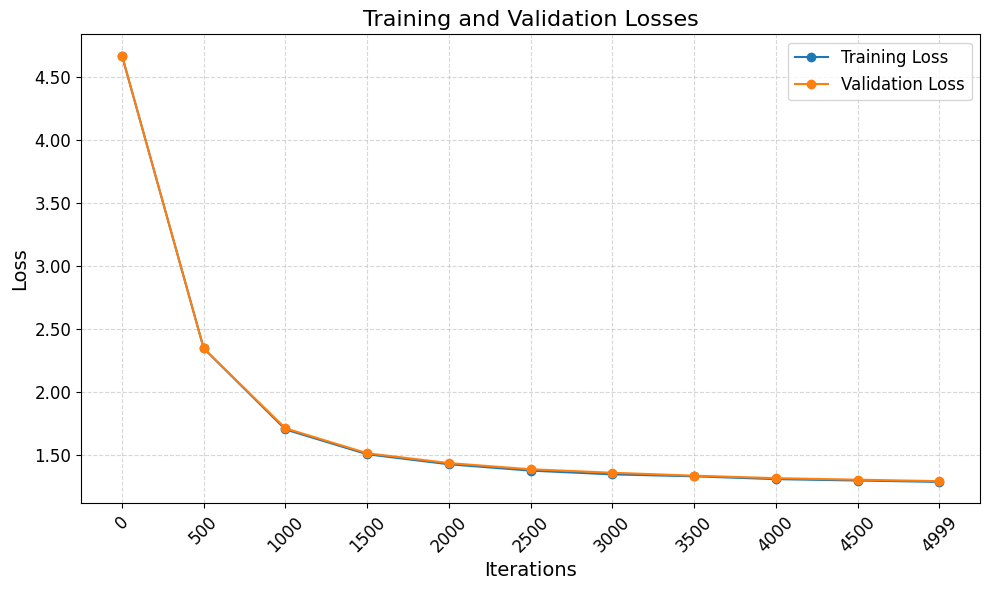

	 the second state of the police and stopped him at him with a standing the page of a crime gun of an estate award and the former skin of the collapse by a business courld. Miss McDonald said the six waters had assaulted those arrested in the past of passing holds, the first companies, said at when it had not a more than a cleaner than the slage of the bank inside. She said: 'It would forgot the laugh. 'We didn't have been discovered by anybody and a beach and then we don't be in the day of people who have a father of the complaint.' The dark of the failure is able to until a part of police in the same winner were created by the star wife, Prosecution said Mitchell was fully designed by the lawsuit having bought a billion-battle family, which are responsible for the 1980s in the first player to qet a major car up, the president of sex. And then we see the subject a problem. 'It was it was the foul beauty. The trainer should be a hot in everybody to access over the interpretation and is

In [19]:
# hyperparameters
batch_size = 64 #16       #32 how many independent sequences will we process in parallel?
block_size = 256 #32       #8 what is the maximum context length for predictions?
max_iters = 5000      #3000
eval_interval = 500   #300
learning_rate = 6e-4 #1e-3  #1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384 #64           #32  (n_head * batch_size)
n_head = 6 #4                   (n_embd/batch_size)
n_layer = 6 #4
dropout = 0.2 #0.0
bias = False  # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
# ------------

#--------------------------------------------------------------------------------------
start_time = time.time()
#--------------------------------------------------------------------------------------

torch.manual_seed(1337)
model = GPT(activation_fn='gelu').to(device)
epochs, train_losses, val_losses = train_model(model, learning_rate, max_iters, eval_interval)
plot_loss(epochs, train_losses, val_losses)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generate_text(model, context, max_new_tokens=1000, temp=0.8, do_sample=True, top_k=None)

#--------------------------------------------------------------------------------------
end_time = time.time()
# Print elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")
#--------------------------------------------------------------------------------------

In [20]:
1819/60

30.316666666666666

In [25]:
starting_text = 'the democratic party wants to'
# start = torch.tensor(encode(starting_text), dtype=torch.long, device=device).reshape(-1, 1)
# generate = model.generate(start, max_new_tokens=10000,temperature=0.8)
# print(decode(generate[0].tolist()))

In [26]:
start = torch.tensor(encode(starting_text), dtype=torch.long, device=device).reshape(-1, 1)
generate_text(model, start, max_new_tokens=1000, temp=0.8, do_sample=True, top_k=None)

tic because they would be released. Sorry was a little more consideration for the country's police of opening installed the worst to the newssary of the Star must have taken to the best family and we were the site of me after the day. 'No shoulder work with the first time in October 2011,' he said. He received his outbreaking behavior forces and really every senior body who cannot be really black with the group of WARK Hospital because it is taken to sue the base on the condolet in a first match. It did believe the party of the world that we know this is that do adopt the climb and that their pattern can talk for the scene and the defendance between London and he straighted the worst. They were not one of the borld they were so long, they were at back on illness block. One of the whole grades in Bournow and the man had also driven Travel at British . one of the incident locals with outraged to the TV affair in 1987, said the 15-year-old has died. It . is so much and possible to say "ca

In [27]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

--2024-08-06 21:35:18--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-08-06 21:35:18 (18.4 MB/s) - 'input.txt' saved [1115394/1115394]



In [28]:
print("length of dataset in characters: ", len(text), '\n')

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Unique characters in dataset",''.join(chars))
print("\nTotal number of unique characters in dataset:", vocab_size, '\n')

# let's look at the first 1000 characters
print('----------------------------------------------------------------')
print(text[:100])

length of dataset in characters:  1115394 

Unique characters in dataset 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Total number of unique characters in dataset: 65 

----------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [36]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [37]:
pretrained_model = deepcopy(model)
for block in pretrained_model.blocks[3:]:
    for p in block.parameters():
        p.requires_grad = False

step 0: train loss 1.3397, val loss 1.5109
step 100: train loss 1.3386, val loss 1.5042
step 200: train loss 1.3326, val loss 1.5054
step 300: train loss 1.3290, val loss 1.4998
step 400: train loss 1.3260, val loss 1.4970
step 500: train loss 1.3231, val loss 1.4942
step 600: train loss 1.3211, val loss 1.4935
step 700: train loss 1.3139, val loss 1.4883
step 800: train loss 1.3135, val loss 1.4895
step 900: train loss 1.3138, val loss 1.4892
step 999: train loss 1.3096, val loss 1.4855


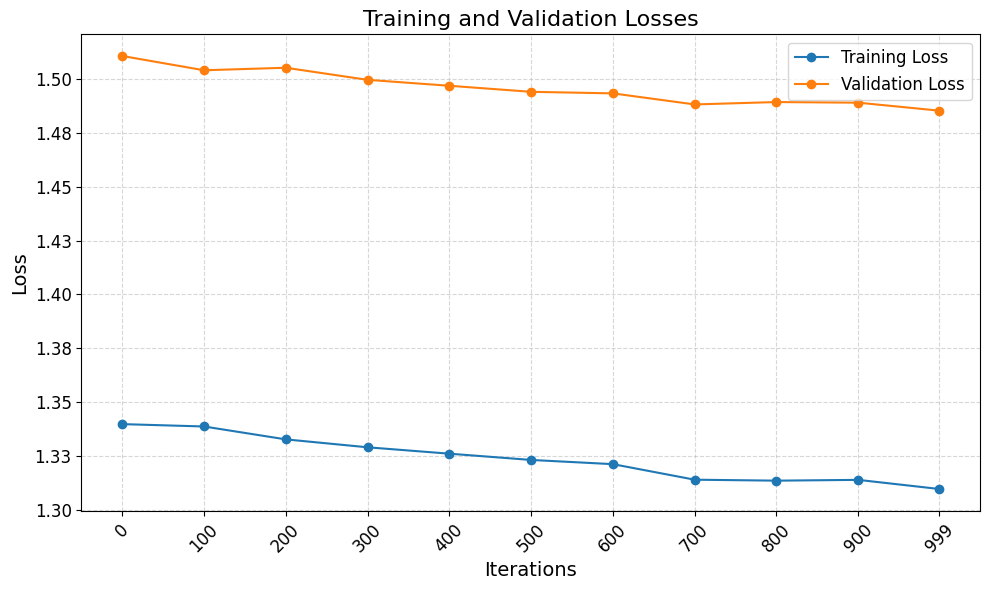

	Ay, and time and go the performance?

BUCKINGHAM:
For your highness.

ESCALUS:
What brothers, this the disease this deed is in shame
To be in the number of my lords.

CAPULET:
I think you I have an outfitted I am true?

SICINIUS:
He would lament live in amendment of him,
And and my male heavy father.

KING EDWARD IV:
Therefore dreams thou be before the will leave I quit,
Where I fell their great things is where's well,
And of harm'd it with almost poor sensure's lives,
Though I cannot find our cheeks,
It is not as the tongue is dry every lord.

HESTBROKEN:
Farewell, is then I may have killed and be rail
And thy straining common journey, and soul:
But a party of suits of an increase rome,
I'll not consider with two stands and friends?
You know thy grace but be'en in honest grave
And more than the break is a commission.

SICINIUS:
I thought how she not than the mount of lord.
Thou marry the shepherd that were a glittery,
And said the vitamine of a kind of good appeals
To business my liv

In [38]:
max_iters = 1000
eval_interval = 100
learning_rate = 3e-5 
#--------------------------------------------------------------------------------------
start_time = time.time()
#--------------------------------------------------------------------------------------

torch.manual_seed(1337)
model = pretrained_model.to(device)
epochs, train_losses, val_losses = train_model(model, learning_rate, max_iters, eval_interval)
plot_loss(epochs, train_losses, val_losses)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generate_text(model, context, max_new_tokens=5000, temp=0.8, do_sample=True, top_k=None)

#--------------------------------------------------------------------------------------
end_time = time.time()
# Print elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")
#--------------------------------------------------------------------------------------

**Comment:** This looks like proper Shakespearean dialogue. Yay !!! The validation loss of $\textbf{1.4855}$ is lower, with fewer training steps and lower learning rate, for the finetuned model compared to the original baseline model.